# mlbotの初心者向けチュートリアル(BitFlyer版)

richmanbtcさんのmlbotの初心者向けチュートリアルをBitFlyer向けに記載したものです。

## 必要なライブラリのインポート

以下のコードでは必要なライブラリをインポートしています。

In [2]:
import math

import ccxt
from crypto_data_fetcher.gmo import GmoFetcher
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib
import datetime,time,requests
from datetime import timedelta

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

## データを用意
BitFlyerのAPI(チャート用)を利用して1分足のOHLCVを取得します。

In [4]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}

start_datetime = datetime.datetime.strptime("2018-01-02 00:00:00", "%Y-%m-%d %H:%M:%S")
end_datetime = datetime.datetime.strptime("2018-01-01 00:00:00", "%Y-%m-%d %H:%M:%S")
target_coin = "FX_BTC_JPY"


ohlc_list=[]
while start_datetime > end_datetime:
    unixtime = start_datetime.timestamp() * 1000
    response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
    ohlc_list.extend(response)
    start_datetime -= timedelta(minutes=720)
    time.sleep(1)


df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
df_1m.set_index("timestamp",inplace=True)
df_1m.sort_index(inplace=True)
display(df_1m)

df_1m.to_pickle('df_bf_fx_ohlcv_1m.pkl')

,op,hi,lo,cl,volume,volume_buy_sum,volume_sell_sum,volume_buy,volume_sell
timestamp,,,,,,,,,
2018-01-01 00:01:00+00:00,1884160.0,1889890.0,1884160.0,1888999.0,12.453978,6147.622671,4781.211680,3.171679,9.282299
2018-01-01 00:02:00+00:00,1888999.0,1889892.0,1884161.0,1885787.0,24.037741,5969.723071,4817.574471,11.493328,12.544412
2018-01-01 00:03:00+00:00,1885787.0,1886074.0,1880740.0,1882043.0,30.480556,5813.856981,4713.962894,18.496474,11.984082
2018-01-01 00:04:00+00:00,1882043.0,1886247.0,1882000.0,1882961.0,20.839496,5867.336392,4726.835472,11.470742,9.368754
2018-01-01 00:05:00+00:00,1882961.0,1884983.0,1879690.0,1882581.0,47.991520,6056.577528,4757.127376,32.205018,15.786502
...,...,...,...,...,...,...,...,...,...
2018-01-01 23:56:00+00:00,1865773.0,1866435.0,1864044.0,1866249.0,18.113410,5676.054818,4910.970476,3.511224,14.602187
2018-01-01 23:57:00+00:00,1866249.0,1866631.0,1864334.0,1865996.0,15.881969,5730.419310,4947.833662,6.218035,9.663934
2018-01-01 23:58:00+00:00,1865996.0,1867000.0,1864928.0,1865432.0,29.414456,5678.508553,4928.212705,4.848532,24.565924


1分足のOHLCVを15分足に変換します。

In [6]:
df_1m = pd.read_pickle('df_bf_fx_ohlcv_1m.pkl')
rule = "15T"
df = pd.DataFrame()
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

display(df)
df.to_pickle('df_bf_fx_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2018-01-01 00:00:00+00:00,1884160.0,1889892.0,1875000.0,1882701.0,437.318043
2018-01-01 00:15:00+00:00,1882701.0,1883928.0,1872000.0,1878549.0,408.358884
2018-01-01 00:30:00+00:00,1878549.0,1885442.0,1864750.0,1867998.0,468.416029
2018-01-01 00:45:00+00:00,1867998.0,1877000.0,1864120.0,1867622.0,563.751007
2018-01-01 01:00:00+00:00,1867622.0,1870730.0,1862060.0,1865451.0,446.677440
...,...,...,...,...,...
2021-12-24 23:00:00+00:00,6026957.0,6030536.0,5999246.0,6000811.0,67.611664
2021-12-24 23:15:00+00:00,6001309.0,6025201.0,5994545.0,6019905.0,40.160955
2021-12-24 23:30:00+00:00,6019905.0,6036021.0,6013439.0,6029766.0,32.310939


## maker手数料カラムを追加
0円とする。SFDの手数料の考慮は省略。  
https://bitflyer.com/ja-jp/commission

In [8]:
df = pd.read_pickle('df_bf_fx_ohlcv.pkl')
df['fee'] = 0.0
display(df)
df.to_pickle('df_bf_fx_ohlcv_with_fee.pkl')

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2018-01-01 00:00:00+00:00,1884160.0,1889892.0,1875000.0,1882701.0,437.318043,0.0
2018-01-01 00:15:00+00:00,1882701.0,1883928.0,1872000.0,1878549.0,408.358884,0.0
2018-01-01 00:30:00+00:00,1878549.0,1885442.0,1864750.0,1867998.0,468.416029,0.0
2018-01-01 00:45:00+00:00,1867998.0,1877000.0,1864120.0,1867622.0,563.751007,0.0
2018-01-01 01:00:00+00:00,1867622.0,1870730.0,1862060.0,1865451.0,446.677440,0.0
...,...,...,...,...,...,...
2021-12-24 23:00:00+00:00,6026957.0,6030536.0,5999246.0,6000811.0,67.611664,0.0
2021-12-24 23:15:00+00:00,6001309.0,6025201.0,5994545.0,6019905.0,40.160955,0.0
2021-12-24 23:30:00+00:00,6019905.0,6036021.0,6013439.0,6029766.0,32.310939,0.0


## 特徴量エンジニアリング

In [3]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

df = pd.read_pickle('df_bf_fx_ohlcv_with_fee.pkl')
df = df.dropna()
df = calc_features(df)
display(df)
df.to_pickle('df_bf_fx_features.pkl')

,op,hi,lo,cl,cl_spot,volume,volume_buy,volume_sell,fee,BBANDS_upperband,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00+00:00,1884160.0,1889892.0,1884160.0,1885787.0,1675009.0,36.491719,14.665007,21.826712,0.0,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:03:00+00:00,1885787.0,1886247.0,1879690.0,1882581.0,1669040.0,99.311572,62.172234,37.139338,0.0,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:06:00+00:00,1882581.0,1882581.0,1875000.0,1879758.0,1670320.0,165.822138,85.421648,80.400490,0.0,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:09:00+00:00,1879758.0,1883619.0,1877658.0,1880000.0,1670000.0,80.113154,45.823698,34.289455,0.0,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:12:00+00:00,1880000.0,1886350.0,1878016.0,1882701.0,1669995.0,55.579460,24.792812,30.786648,0.0,4369.664223,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,2193.632111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24 23:48:00+00:00,6020218.0,6022849.0,6007169.0,6010998.0,5802095.0,10.655442,5.586840,5.068601,0.0,25442.361507,...,0.383325,-0.382042,0,1.153027,0.933708,16410.857143,89.961799,-3087.285714,1499.857143,8157.480753
2021-12-24 23:51:00+00:00,6010536.0,6026704.0,6009593.0,6024327.0,5814007.0,3.891399,1.779701,2.111698,0.0,17023.749537,...,0.012386,-0.698295,0,1.248708,0.931971,3644.885714,89.959782,-14875.457143,1424.641758,6506.524768
2021-12-24 23:54:00+00:00,6024807.0,6025089.0,6016285.0,6022927.0,5813150.0,2.014245,0.943886,1.070359,0.0,13225.432319,...,-0.348934,-0.909397,0,1.278570,0.926282,3571.571429,89.940001,-8842.714286,954.945055,6212.516159


## 学習に使う特徴量の定義

In [7]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


## 目的変数の計算

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


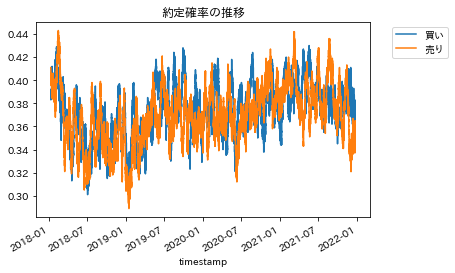

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


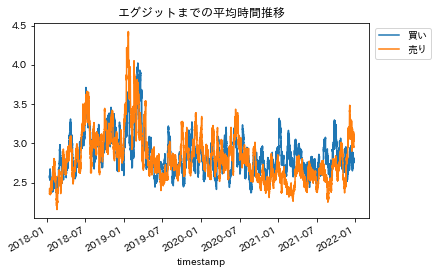

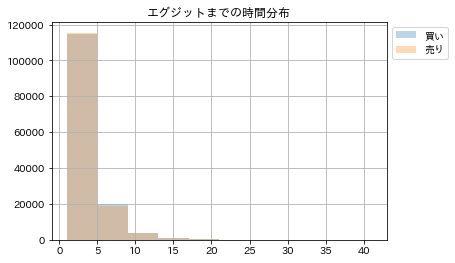

毎時刻、この執行方法でトレードした場合の累積リターン


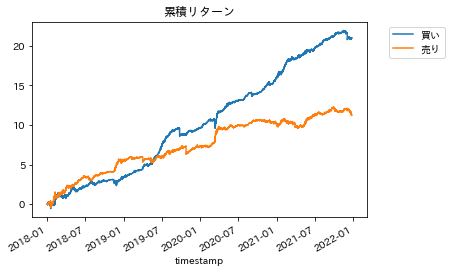

In [16]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_bf_fx_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_bf_fx_y.pkl')

## モデルの学習とOOS予測値計算

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


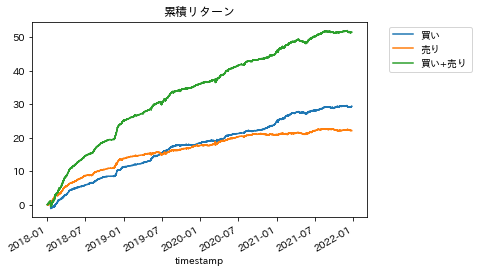

In [9]:
df = pd.read_pickle('df_bf_fx_y.pkl')
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, 'model_y_buy_bffx.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, 'model_y_sell_bffx.xz', compress=True)

# 通常のCV
cv_indicies = list(KFold().split(df))
# ウォークフォワード法
# cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_bf_fx_fit.pkl')

## バックテストと検定

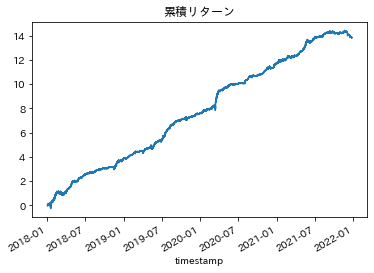

ポジション推移です。変動が細かすぎて青色一色になっていると思います。
ちゃんと全ての期間でトレードが発生しているので、正常です。


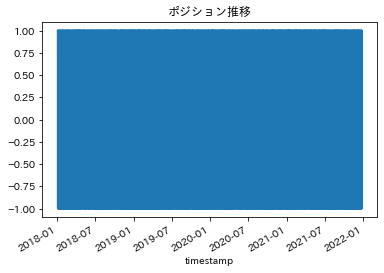

ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。


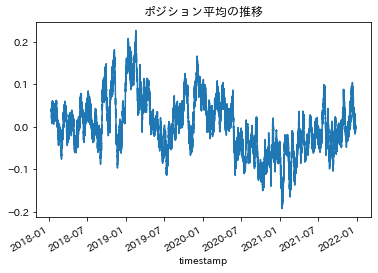

取引量(ポジション差分の絶対値)の累積です。
期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。


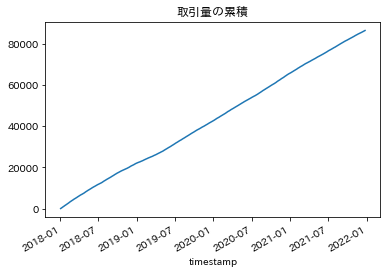

t検定
t値 8.337877878958139
p値 7.631417276003502e-17
p平均法 n = 5
p平均 0.0032317644638436456
エラー率 9.180520009953698e-12


In [23]:
@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

df = pd.read_pickle('df_bf_fx_fit.pkl')

# バックテストで累積リターンと、ポジションを計算
df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

df['cum_ret'].plot()
plt.title('累積リターン')
plt.show()

print('ポジション推移です。変動が細かすぎて青色一色になっていると思います。')
print('ちゃんと全ての期間でトレードが発生しているので、正常です。')
df['poss'].plot()
plt.title('ポジション推移')
plt.show()

print('ポジションの平均の推移です。どちらかに偏りすぎていないかなどを確認できます。')
df['poss'].rolling(1000).mean().plot()
plt.title('ポジション平均の推移')
plt.show()

print('取引量(ポジション差分の絶対値)の累積です。')
print('期間によらず傾きがだいたい同じなので、全ての期間でちゃんとトレードが行われていることがわかります。')
df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('取引量の累積')
plt.show()

print('t検定')
x = df['cum_ret'].diff(1).dropna()
t, p = ttest_1samp(x, 0)
print('t値 {}'.format(t))
print('p値 {}'.format(p))

# p平均法 https://note.com/btcml/n/n0d9575882640
def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p平均法 n = {}'.format(p_mean_n))
print('p平均 {}'.format(p_mean))
print('エラー率 {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))


## 実運用

In [24]:
# 最大ポジションサイズと月次利益の見積もり例
amount_per_day_jpy = 1000.0 * 10000 * 10000 # 1日の売買代金 1000億円
order_interval_min = 15.0 # 15分間隔で発注
monthly_return = 0.5 # 月次利益率 50%
my_order_ratio = 0.01 # 自分のボットの売買代金割合 1%

max_position_size = amount_per_day_jpy / (24 * 60) * order_interval_min * my_order_ratio
monthly_profit = max_position_size * monthly_return
print('最大ポジションサイズ {}円'.format(max_position_size))
print('月次利益 {}円'.format(monthly_profit))

最大ポジションサイズ 10416666.666666668円
月次利益 5208333.333333334円


##　売買判定 

BitFlyerが用意しているAPIからOHLCVを取得しモデルを利用して売買判定を出力します。
買い予想の数値(y_pred_buy)が0以上であれば買い、売り予想の数値(y_pred_sell)が0以上であれば売りと判断しています。
このためポジションの出力では買い予想の数値(y_pred_buy)のみが0以上の時に買い、売り予想の数値(y_pred_sell)のみが0以上の時に売りと判断しています。

In [41]:
#OHLCV取得
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.76 Safari/537.36'}
unixtime = datetime.datetime.now().timestamp() * 1000
target_coin = "FX_BTC_JPY"
ohlc_list=[]

#1000本以上の1分足を取得
while len(ohlc_list) < 1000:
    response = requests.get( f"https://lightchart.bitflyer.com/api/ohlc?symbol={target_coin}&period=m&before={unixtime}", headers= headers).json()
    ohlc_list.extend(response)
    current_after = datetime.datetime.fromtimestamp(response[-1][0]/1000)
    next_before = current_after - timedelta(minutes=1)
    unixtime = int(next_before.timestamp() * 1000)
    time.sleep(1)

df_1m = pd.DataFrame(ohlc_list,columns=['timestamp', 'op', 'hi', 'lo', 'cl', 'volume','volume_buy_sum','volume_sell_sum','volume_buy','volume_sell'])
df_1m["timestamp"] = pd.to_datetime(df_1m["timestamp"]/1000,unit='s', utc=True)
df_1m.set_index("timestamp",inplace=True)
df_1m.sort_index(inplace=True)

#15分足に変換
df = pd.DataFrame()
rule = "15T"
df["op"] = df_1m["op"].resample(rule).first()
df["hi"] = df_1m["hi"].resample(rule).max()
df["lo"] = df_1m["lo"].resample(rule).min()
df["cl"] = df_1m["cl"].resample(rule).last()
df["volume"] = df_1m["volume"].resample(rule).sum()

#特徴量の計算
df_features = calc_features(df)

#モデルの読み込み
model_y_buy = joblib.load('./model_y_buy_bffx.xz')
model_y_sell = joblib.load('./model_y_sell_bffx.xz')

#推論
df_features["predict_y_buy"] = model_y_buy.predict(df_features[features])
df_features["predict_y_sell"] = model_y_sell.predict(df_features[features])

#ポジションの判定

#買いポジションの判定
def calc_position_buy(x):
    buy = x["predict_y_buy"]
    if buy > 0:
        return "buy"
    else:
        return "none"
    
#売りポジションの判定
def calc_position_sell(x):
    buy = x["predict_y_sell"]
    if buy > 0:
        return "sell"
    else:
        return "none"

df_features["position_buy"] = df_features.apply(calc_position_buy,axis=1)
df_features["position_sell"] = df_features.apply(calc_position_sell,axis=1)

display(df_features)

position_buy = df_features["position_buy"].iloc[-1]
position_sell = df_features["position_sell"].iloc[-1]

if position_buy == "buy" and position_sell == "none":
    print("Buy Bitcoin")
elif position_sell == "sell" and position_buy == "none":
    print("Sell Bitcoin")
else:
    print("N/A")


,op,hi,lo,cl,volume,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,...,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,predict_y_buy,predict_y_sell,position_buy,position_sell
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,5507935.0,5540549.0,5507692.0,5519988.0,31.393658,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.835352e-04,0.001276,none,sell
2022-01-01 00:15:00+00:00,5517649.0,5528738.0,5507452.0,5523941.0,16.190182,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.835352e-04,0.001276,none,sell
2022-01-01 00:30:00+00:00,5525100.0,5560395.0,5520957.0,5550137.0,42.902919,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.835352e-04,0.001276,none,sell
2022-01-01 00:45:00+00:00,5549884.0,5577650.0,5543469.0,5559003.0,49.327859,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.835352e-04,0.001276,none,sell
2022-01-01 01:00:00+00:00,5560761.0,5563258.0,5541964.0,5562746.0,48.097128,26212.645805,-9448.0,-45108.645805,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,17830.322902,1.017011e-04,0.002323,buy,sell
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-02 02:15:00+00:00,5656501.0,5658146.0,5643010.0,5645250.0,15.532760,13944.334836,3158.0,-7628.334836,15234.307678,7477.477012,...,0.827469,10447.228571,-89.952575,26152.914286,-1208.129670,5393.167418,4.095812e-05,0.000002,buy,sell
2022-01-02 02:30:00+00:00,5644037.0,5657890.0,5640385.0,5649442.0,16.596478,10651.961441,2313.5,-6024.961441,15098.802743,8362.268818,...,0.852215,826.571429,-89.971731,27175.000000,-2026.802198,4169.230721,5.169818e-05,0.000006,buy,sell
2022-01-02 02:45:00+00:00,5649453.0,5655116.0,5647003.0,5649154.0,6.841381,6348.989819,-911.7,-8172.389819,11700.052107,5901.832120,...,0.844938,-2804.942857,-89.977005,29586.514286,-2491.650549,3630.344909,3.157610e-07,0.000017,buy,sell


N/A
